# Линейная регрессия 

In [50]:
%tensorflow_version 2.x

In [51]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [53]:
from sklearn.datasets import load_boston

In [54]:
x, y = load_boston(return_X_y=True)
x.shape, y.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

((506, 13), (506,))

In [55]:
#Разделим на train и test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

#Пронормируем входные данные от 0 до 1
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [56]:
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
import seaborn as sns

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 6)) + "\n" +
            "Train MAE:\t" + str(round(mae(train_true_values, train_pred_values), 6)) + "\n" +
            "Train MSE:\t" + str(round(mse(train_true_values, train_pred_values), 6)))

    print("\n" +
            "Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 6)) + "\n" +
            "Test MAE:\t" + str(round(mae(test_true_values, test_pred_values), 6)) + "\n" +
            "Test MSE:\t" + str(round(mse(test_true_values, test_pred_values), 6)))
    
    plt.figure(figsize=(15,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()
  

In [57]:
def madel_fit(x_train, y_train, x_test, y_test, 
                epochs=20, number_neurons=128, number_layers=2, optimizer='adam', 
                activation='linear', loss='mse', metrics='r2' ):

    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(x_train.shape[1],)))
    if number_layers >= 2:
        for i in range(number_layers-1):  
            model.add(keras.layers.Dense(number_neurons, activation=activation)) 
    model.add(keras.layers.Dense(1, activation='linear'))# Только 1 выход, раз задача регрессии

    if metrics == 'r2': metrics=tfa.metrics.RSquare()
    #Compile the model.
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metrics]
                )
    if tf.config.experimental.list_physical_devices("GPU"):
        with tf.device("GPU:0"):
            # Train the model.
            history_train = model.fit(x_train,
                                    y_train,
                                    epochs=epochs,
                                    batch_size=200,
                                    validation_data = (x_test, y_test),
                                    verbose=0
                                    )
    else:
        with tf.device("CPU:0"):
            history_train = model.fit(x_train,
                                        y_train,
                                        epochs=epochs,
                                        batch_size=200,
                                        validation_data = (x_test, y_test),
                                        verbose=0
                                        )

    return model, history_train

# Практическое задание

## 1. Постройте нейронную сеть(берем простую линейную сеть, меняем число слоев, число нейронов, типы активации, тип оптимизатора) на датасете from sklearn.datasets import load_boston.

### Подберём число нейронов

In [58]:
#количество эпох
epoch = 100

In [59]:
results_1 = {'neurons': [],
             'r2_train': [],
             'r2_test': []}

_neurons = [2**i for i in range(6,12)]

for i in tqdm(_neurons):
    
    _, hist = madel_fit(x_train, y_train, x_test, y_test, number_neurons=i, epochs=epoch)

    results_1['neurons'].append(i)
    results_1['r2_train'].append(hist.history['r_square'][-1])
    results_1['r2_test'].append(hist.history['val_r_square'][-1])

100%|██████████| 6/6 [00:29<00:00,  4.85s/it]


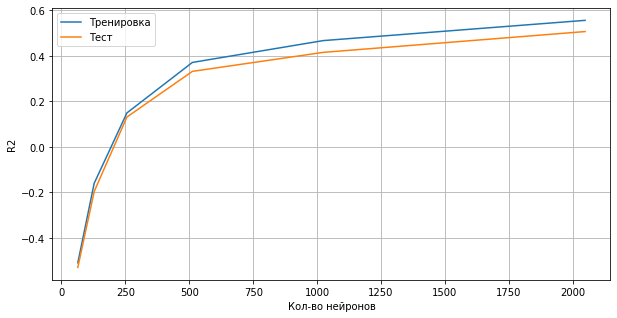

In [60]:
plt.figure(figsize=(10, 5))
plt.grid('On')
plt.ylabel('R2')
plt.xlabel('Кол-во нейронов')
plt.plot(results_1['neurons'], results_1['r2_train'], label = 'Тренировка')
plt.plot(results_1['neurons'], results_1['r2_test'], label = 'Тест')
plt.legend()
plt.show()

_Здесь лучше себя показала модель с самым большим количествам нейронов, но я для дальнейшей работы возьму 1028_

### Подберём число слоев

In [61]:
results_2 = {'layers': [],
             'r2_train': [],
             'r2_test': []}

_layers = np.arange(2, 6)

for i in tqdm(_layers):

    _, hist = madel_fit(x_train, y_train, x_test, y_test, number_neurons=1024, epochs=epoch, number_layers=i)

    results_2['layers'].append(i)
    results_2['r2_train'].append(hist.history['r_square'][-1])
    results_2['r2_test'].append(hist.history['val_r_square'][-1])

100%|██████████| 4/4 [00:19<00:00,  4.82s/it]


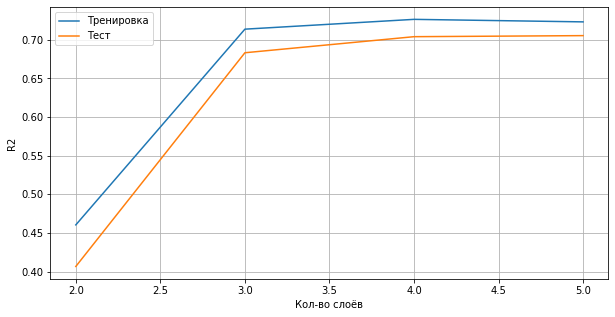

In [62]:
plt.figure(figsize=(10, 5))
plt.grid('On')
plt.ylabel('R2')
plt.xlabel('Кол-во слоёв')
plt.plot(results_2['layers'], results_2['r2_train'], label = 'Тренировка')
plt.plot(results_2['layers'], results_2['r2_test'], label = 'Тест')
plt.legend()
plt.show()

_Здесь лучше себя показала модель с 4-мя слоями_

### Подберём типы активации

In [63]:
# Возьмем все известные
activations = ['elu', 'exponential', 'gelu', 'hard_sigmoid','linear', 'relu', 'selu',
               'sigmoid', 'softmax', 'softplus',  'softsign', 'swish', 'tanh']
results_3 = {'activation': [],
             'r2_train': [],
             'r2_test': []}

for i in tqdm(activations):

    _, hist = madel_fit(x_train, y_train, x_test, y_test, 
                        number_neurons=1024, epochs=epoch, number_layers=4,
                        activation=i)
    
    results_3['activation'].append(i)
    results_3['r2_train'].append(hist.history['r_square'][-1])
    results_3['r2_test'].append(hist.history['val_r_square'][-1])

100%|██████████| 13/13 [00:55<00:00,  4.25s/it]


In [64]:
pd.DataFrame(results_3).sort_values('r2_test', ascending=False).reset_index(drop=True)

,activation,r2_train,r2_test
0,relu,0.923510,0.857233
1,selu,0.867423,0.829005
2,gelu,0.801432,0.810548
3,tanh,0.846980,0.794506
4,elu,0.809506,0.791700
5,swish,0.790512,0.774250
6,softsign,0.827911,0.756519
7,linear,0.722692,0.708596
8,softplus,0.581539,0.547635
9,hard_sigmoid,-0.000209,-0.020909


_Здесь лучше себя показала "relu"_

### Подберём оптимизаторы

In [65]:
# Возьмем все известные
optimizers = ['Adadelta','Adagrad','Adam','Adamax',
              'Ftrl', 'Nadam','RMSprop','SGD']

results_4 = {'optimizers': [],
             'r2_train': [],
             'r2_test': []}

for i in tqdm(optimizers):

    _, hist = madel_fit(x_train, y_train, x_test, y_test, 
                        number_neurons=1024, epochs=epoch, number_layers=4,
                        activation='relu', optimizer=i)
    
    results_4['optimizers'].append(i)
    results_4['r2_train'].append(hist.history['r_square'][-1])
    results_4['r2_test'].append(hist.history['val_r_square'][-1])

100%|██████████| 8/8 [00:28<00:00,  3.58s/it]


In [66]:
pd.DataFrame(results_4).sort_values('r2_test', ascending=False).reset_index(drop=True)

,optimizers,r2_train,r2_test
0,Adam,0.926896,0.861159
1,Adamax,0.860985,0.831221
2,Nadam,0.683268,0.807636
3,RMSprop,0.886479,0.730689
4,Adagrad,0.646235,0.617443
5,Ftrl,0.435142,0.402120
6,Adadelta,-5.714069,-5.884953
7,SGD,NaN,NaN


_Здесь лучше себя показал Adam_

## 2. Измените функцию потерь и метрику для этой задачи. Постройте 10-15 вариантов и сведите результаты их работы в таблицу Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

In [67]:
losses = ['LogCosh', 'MAE', 'MSE', 'MSLE']
metrics = ['r2', 'MAE', 'MSE', 'MSLE']

results_5 = {'metric': [],
             'loss': [],
             'r2_test': []
             }

for loss in tqdm(losses):
    for metric in metrics:

        model, _ = madel_fit(x_train, y_train, x_test, y_test, 
                        number_neurons=1024, epochs=epoch, number_layers=4,
                        activation='relu',optimizer='Adam', loss=loss, metrics=metric)
        
        y_pred = model.predict(x_test, verbose=0)
        r2_test = r2(y_test, y_pred)

        results_5['loss'].append(loss)
        results_5['metric'].append(metric)
        results_5['r2_test'].append(r2_test) 

100%|██████████| 4/4 [00:51<00:00, 12.86s/it]


In [68]:
pd.DataFrame(results_5).sort_values('r2_test', ascending=False).reset_index(drop=True)

,metric,loss,r2_test
0,r2,MSE,0.864294
1,MAE,MSE,0.861119
2,MSLE,MSE,0.859477
3,MAE,LogCosh,0.858445
4,r2,LogCosh,0.857974
5,MSE,MSE,0.853922
6,MSLE,LogCosh,0.853527
7,r2,MAE,0.846320
8,r2,MSLE,0.846127
9,MSE,MSLE,0.844217


_Здесь лучше себя показала связка MSLE-MSE_

### Оптимальный вариант

In [69]:
model, hist = madel_fit(x_train, y_train, x_test, y_test, 
                        number_neurons=1024, epochs=epoch, number_layers=4,
                        activation='relu',optimizer='Adam', loss='MSE', metrics='MSLE')

y_train_preds = model.predict(x_train)
y_test_preds = model.predict(x_test)

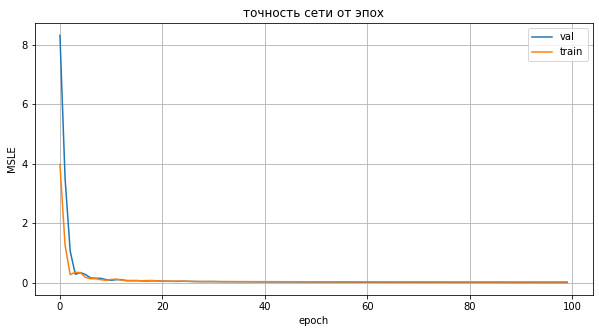

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['MSLE'] ,label='val')
plt.plot(hist.history['val_MSLE'] ,label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSLE')
plt.title('точность сети от эпох')
plt.grid()
plt.show()

Train R2:	0.929103
Train MAE:	1.78725
Train MSE:	6.249202

Test R2:	0.862217
Test MAE:	2.206158
Test MSE:	10.427239


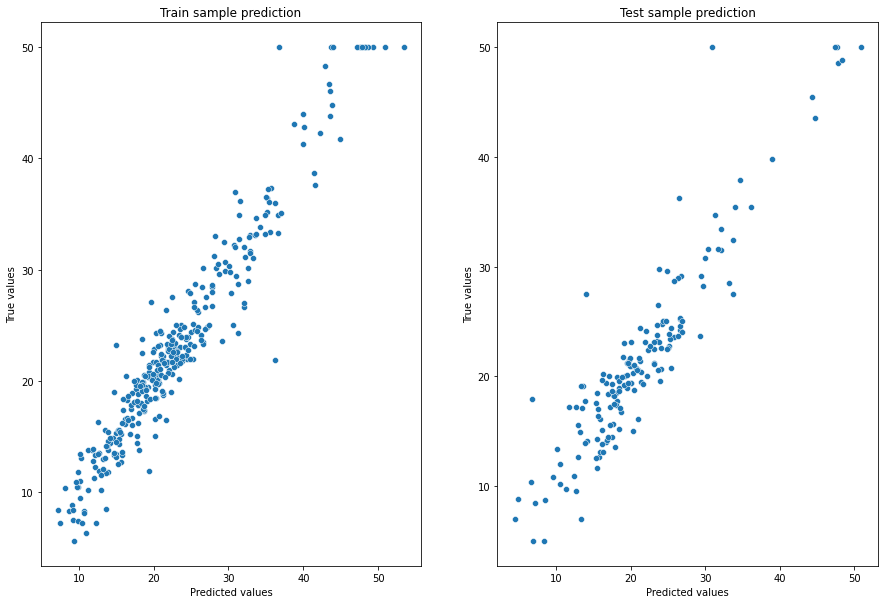

In [71]:
evaluate_preds(y_train, y_train_preds.reshape(1, y_train_preds.shape[0])[0], y_test, y_test_preds.reshape(1, y_test_preds.shape[0])[0])